In [1]:
# Imports you'll need.
from collections import Counter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI

%matplotlib inline

In [2]:
# This method is done for you. Make sure to put your credentials in twitter.cfg.
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
print('Established Twitter connection.')


Established Twitter connection.


In [3]:
def read_candidates(filename):
    f = open('candidates.txt', 'r')
    candidates = []
    count = 0
    for line in f: 
        temp =  line.strip('\n').split(' ')
        if count%2 == 0:
            candidates.append(tuple(temp))
        count += 1

    return candidates
        

candidates = read_candidates('candidates.txt')  
print('Read %d candidates' % len(candidates))
print('\n'.join(str(x) for x in candidates))

Read 15 candidates
('HillaryClinton', 'D')
('BernieSanders', 'D')
('MartinOMalley', 'D')
('JoeBiden', 'D')
('JimWebbUSA', 'D')
('realDonaldTrump', 'R')
('JebBush', 'R')
('RealBenCarson', 'R')
('marcorubio', 'R')
('ScottWalker', 'R')
('tedcruz', 'R')
('CarlyFiorina', 'R')
('GovMikeHuckabee', 'R')
('govchristie', 'R')
('DrRandPaul', 'R')


In [4]:
# separate candidates by party.
republicans = [c[0] for c in candidates if c[1] == 'R']
democrats = [c[0] for c in candidates if c[1] == 'D']
print('%d republicans, %d democrats' % (len(republicans), len(democrats)))

10 republicans, 5 democrats


In [5]:
def robust_request(twitter, resource, params, max_tries=10):
    
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print >> sys.stderr, 'Got error:', request.text, '\nsleeping for 15 minutes.'
            sys.stderr.flush()
            time.sleep(61 * 15)

In [6]:
def get_friends(screen_name):
    print ('fetching friends for %s' % (screen_name))
    
    temp =[]
    request = robust_request(twitter,'friends/list',{'screen_name' : screen_name, 'count':200})
    followers = [i for i in request]
    for i in range(len(followers)):
        temp.append(followers[i]['screen_name'])
    return temp


In [7]:
def get_all_friends(screen_name):
    """ Get the friends for all the users in usernames.
    I.e., call get_friends for all 15 candidates.
    Args:
        screen_names: a list of Twitter screen names, one per candidate
    Returns:
        a dict mapping each candidate's username (string) to a list of his/her friends (strings)
    """
    return {n: get_friends(n) for n in screen_name}

In [8]:
candidate2friends = get_all_friends(c[0] for c in candidates)


fetching friends for HillaryClinton
fetching friends for BernieSanders
fetching friends for MartinOMalley
fetching friends for JoeBiden
fetching friends for JimWebbUSA
fetching friends for realDonaldTrump
fetching friends for JebBush
fetching friends for RealBenCarson
fetching friends for marcorubio
fetching friends for ScottWalker
fetching friends for tedcruz
fetching friends for CarlyFiorina
fetching friends for GovMikeHuckabee
fetching friends for govchristie
fetching friends for DrRandPaul


In [9]:
#print candidate2friends

def print_num_friends(candidate2friends):
    cand_names = list(candidate2friends.keys())
    cand_names.sort()
    for i in cand_names:
        
        print ('%s %s'%(i,len(candidate2friends[i])))
        
print_num_friends(candidate2friends)    
        


BernieSanders 200
CarlyFiorina 200
DrRandPaul 200
GovMikeHuckabee 200
HillaryClinton 200
JebBush 200
JimWebbUSA 200
JoeBiden 7
MartinOMalley 200
RealBenCarson 51
ScottWalker 200
govchristie 200
marcorubio 200
realDonaldTrump 49
tedcruz 200


In [10]:
# Who is the most popular friend? (i.e., which friend is followed by the most number of candidates?
def count_friends(candidate2friends):
    """ Count how often each friend is followed.
    Args:
        candidate2friends: a dict mapping each candidate to a list of friends
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter
    """
    # TODO
    dict = {}

    k = list(candidate2friends.keys())
    for i in k:
        friends = candidate2friends[i]
        for c in friends:
            if c not in list(dict.keys()):
                dict[c] = 1
            else:
                dict[c] += 1


    c = Counter(dict) 
    return c


friend_counts = count_friends(candidate2friends)
print friend_counts.most_common(5)

[(u'megynkelly', 7), (u'BretBaier', 6), (u'Pontifex', 4), (u'oreillyfactor', 4), (u'FoxNewsSunday', 4)]


In [11]:
print('popular Republican friends:')
republican_counts = count_friends({k: v for k, v in candidate2friends.items() if k in republicans})
print republican_counts.most_common(5)

print('popular Democrat friends:')
democrat_counts = count_friends({k: v for k, v in candidate2friends.items() if k in democrats})
print democrat_counts.most_common(5)

popular Republican friends:
[(u'megynkelly', 7), (u'BretBaier', 6), (u'oreillyfactor', 4), (u'FoxNewsSunday', 4), (u'seanhannity', 4)]
popular Democrat friends:
[(u'Pontifex', 2), (u'GovernorHassan', 2), (u'ABCPolitics', 2), (u'TheLeadCNN', 2), (u'davidaxelrod', 2)]


In [12]:
# Do any candidates from one party actually follow a candidate from another party?
def bipartisan_count(republicans, democrats, candidate2friends):
    print('How many Democrats does each Republican follow?')        
    for r in republicans:
        print('%20s %d' % (r, len(set(democrats) & set(candidate2friends[r]))))
    print('How many Republicans does each Democrat follow?')        
    for d in democrats:
        print('%20s %d' % (d, len(set(republicans) & set(candidate2friends[d]))))

bipartisan_count(republicans, democrats, candidate2friends)

How many Democrats does each Republican follow?
     realDonaldTrump 0
             JebBush 0
       RealBenCarson 0
          marcorubio 0
         ScottWalker 0
             tedcruz 0
        CarlyFiorina 0
     GovMikeHuckabee 0
         govchristie 0
          DrRandPaul 0
How many Republicans does each Democrat follow?
      HillaryClinton 0
       BernieSanders 0
       MartinOMalley 0
            JoeBiden 0
          JimWebbUSA 0


In [13]:
"""
Since there's no direct links between Republicans and Democrats, we propose a different measure.
For each Republican, we cound the number of friends they have that are followed by at least one Democrat.
E.g., If JebBush(R) follows one user, POTUS, and HillaryClinton(D) also follows POTUS, then JebBush will have score 1.
"""
def score_republicans(republicans, democrat_counts, candidate2friends):
    """
    Args:
        republicans...list of strings, one per Republican
        democrat_counts...string-int dict mapping each friend to the number of Democrats who follow thiem.
        candidate2friends...string-list dict mapping each candidate to their list of friends.
    Returns:
        A list of (string, int) pairs, one per Republican candidate, indicating the number
        of friends the Republican has that are also followed by at least one Democrat.
    """
    # TODO
    score = []
    for rep in republicans:
        count = 0
        
        for i in range(len(candidate2friends[rep])):
            for dem in democrat_counts:
                if (candidate2friends[rep][i] == dem):
                    count = count+1
        score.append([rep,count])
    
    return score
    
republican_scores = score_republicans(republicans, democrat_counts, candidate2friends)
print 'How many second-degree Democratic friends does each Republican have?'
print '\n'.join('%20s %d' % (x[0], x[1]) for x in sorted(republican_scores, key=lambda x: x[1], reverse=True))

How many second-degree Democratic friends does each Republican have?
     GovMikeHuckabee 11
             JebBush 5
             tedcruz 4
         govchristie 3
          DrRandPaul 3
         ScottWalker 2
     realDonaldTrump 0
       RealBenCarson 0
          marcorubio 0
        CarlyFiorina 0


In [14]:
def create_graph(candidate2friends, friend_counts):
    """ Create a networkx DiGraph, adding each candidate/friend as a node. 
        Note: while all candidates should be added to the graph,
        only add friends for which friend_counts[friend] > 1. (This is to reduce clutter.)
    Args:
      candidate2friends: dict mapping each candidate to the list of friends
      friend_counts
    Returns:
      A networkx DiGraph
    """
    # TODO
    
    Graph =nx.DiGraph()
    for i in candidate2friends:
        Graph.add_node(i)
        
        temp_list = []
           
        for j in range(len(candidate2friends[i])):
            if(friend_counts[candidate2friends[i][j]]>1):
                Graph.add_edge(i,candidate2friends[i][j])

    return Graph
            

graph = create_graph(candidate2friends, friend_counts)
print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))


graph has 146 nodes and 306 edges


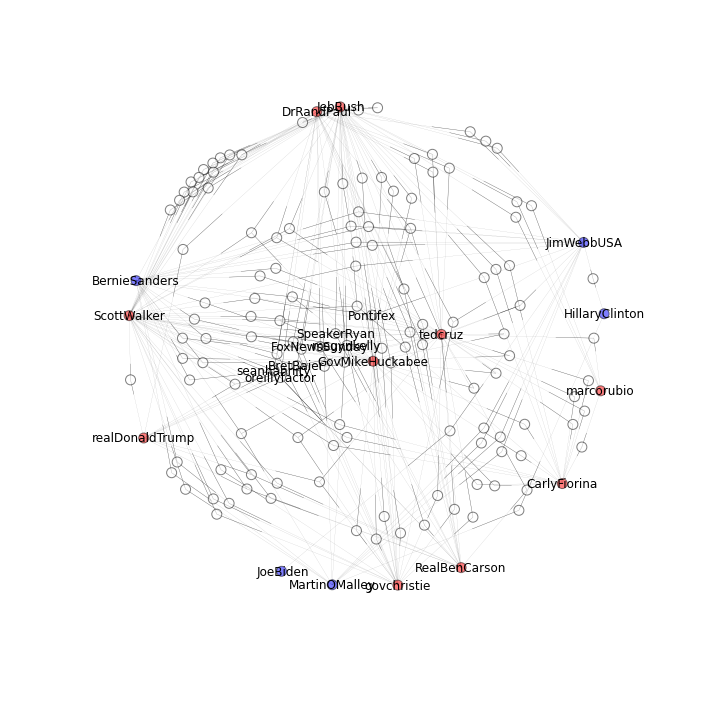

In [15]:
def get_color(name, republicans, democrats):
    if name in republicans:
        return 'r'
    elif name in democrats:
        return 'b'
    else:
        return 'w'

def draw_network(graph, republicans, democrats, candidate2friends, friend_counts):
    colors = [get_color(name, republicans, democrats) for name in graph.nodes()]
    labels = {n: n if n in candidate2friends or friend_counts[n] > 3 else '' for n in graph.nodes()}
    plt.figure(figsize=(12,12))
    nx.draw_networkx(graph, node_color=colors,
                     labels=labels, alpha=.5, width=.1,
                     node_size=100)
    plt.axis("off")
    plt.show()
    
draw_network(graph, republicans, democrats, candidate2friends, friend_counts)

In [16]:
# This will write some information to a text file, which we'll use to help grading.
# Be sure to run this code once at the end and check the resulting file (output.txt) into Github.
import json
outf = open('output.txt', 'wt')
json.dump({'candidates': sorted(candidates),
            'republicans': sorted(republicans),
            'democrats': sorted(democrats),
            'republican_counts': sorted(count_friends({k: v for k, v in candidate2friends.items() if k in republicans}).most_common(10)),
            'democrat_counts': sorted(count_friends({k: v for k, v in candidate2friends.items() if k in democrats}).most_common(10)),
            'num_nodes': len(graph.nodes()),
            'num_edges': len(graph.edges()),
            'republican_scores': sorted(republican_scores),
          }, outf, indent=2, sort_keys=True)
outf.close()
